In [1]:
# Visualize training data

# Visualize downsample with and without gaussian blur

In [1]:
import sys
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import torchvision.transforms as T
to_img = T.ToPILImage()
from PIL import Image
import cv2


In [2]:
sys.path.append("./SRGAN")
sys.path.append("./SRGAN-PyTorch")
import srgan_pytorch
import srgan_pytorch.models as srgan_models
from srgan_pytorch.utils.estimate import iqa

sys.path.append("./ESRGAN-PyTorch")
import esrgan_pytorch
import esrgan_pytorch.models as esrgan_models


sys.path.append("./DIDN")
import color_model


In [3]:
!ls SRGAN-PyTorch/weights/Generator_best.pth

SRGAN-PyTorch/weights/Generator_best.pth


In [4]:
# device = torch.device("cuda:3")
device = torch.device("cpu")

In [5]:
denoise_model = color_model._NetG()
checkpoint = torch.load('DIDN/checkpoint/color_model.pth', map_location=lambda storage, loc: storage)
denoise_model.load_state_dict(checkpoint['model'].state_dict())
denoise_model = denoise_model.to(device)

/afs/csail.mit.edu/u/h/howardzh/.conda/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/afs/csail.mit.edu/u/h/howardzh/.conda/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.activation.PReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/afs/csail.mit.edu/u/h/howardzh/.conda/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'color_model._Residual_Bloc

In [59]:
# model_path = "SRGAN-PyTorch/weights/Generator_best.pth"
model_path = "SRGAN-PyTorch/pretrained_noisy_results/weights/Generator_best.pth"


denoise_srgan = srgan_models.__dict__["srgan"]()
state_dict = torch.load(model_path, map_location=torch.device("cpu"))
print(state_dict['epoch'], state_dict['best_psnr'])
denoise_srgan.load_state_dict(state_dict.get('state_dict', state_dict))
denoise_srgan.eval()
denoise_srgan = denoise_srgan.to(device)

245 tensor(25.3898)


In [7]:
from torch.hub import load_state_dict_from_url
srgan = srgan_models.__dict__["srgan"]()
url = "https://github.com/Lornatang/SRGAN-PyTorch/releases/download/v0.2.2/SRGAN_ImageNet2012-158a3f9e70f45aef607e4146e29cde745e8d9a35972cb067f1ee00cb92254e02.pth"
state_dict = load_state_dict_from_url(url, map_location=torch.device("cpu"))
srgan.load_state_dict(state_dict)
srgan.eval()
srgan = srgan.to(device)


In [8]:
!ls ESRGAN-PyTorch

assets		LICENSE			  scripts	     train.py
benchmarks	pretrained_noisy_results  setup.py	     weights
data		README.md		  test_benchmark.py
esrgan_pytorch	requirements.txt	  test_image.py
hubconf.py	runs			  test_video.py


In [10]:
# model_path = "SRGAN-PyTorch/weights/Generator_best.pth"
model_path = "ESRGAN-PyTorch/pretrained_noisy_results/weights/Generator_best.pth"


denoise_esrgan = esrgan_models.__dict__["esrgan16"]()
state_dict = torch.load(model_path, map_location=torch.device("cpu"))
print(state_dict['epoch'], state_dict['best_psnr'])
denoise_esrgan.load_state_dict(state_dict.get('state_dict', state_dict))
denoise_esrgan.eval()
denoise_esrgan = denoise_esrgan.to(device)

100 tensor(25.5347)


In [11]:
from torch.hub import load_state_dict_from_url
esrgan = esrgan_models.__dict__["esrgan16"]()
url = "https://github.com/Lornatang/ESRGAN-PyTorch/releases/download/v0.2.0/ESRGAN16_DF2K-a03a643d.pth"
state_dict = load_state_dict_from_url(url, map_location=torch.device("cpu"))
esrgan.load_state_dict(state_dict)
esrgan.eval()
esrgan = esrgan.to(device)



In [12]:
CROP_SIZE = 128
UPSCALE_FACTOR = 4

In [13]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        mask = torch.rand(tensor.size()) > 0.9
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + mask * noise
    
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [14]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, GaussianBlur, Grayscale

def is_image_file(filename):
     return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
 return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
 return Compose([
     RandomCrop(crop_size),
     ToTensor(),
 ])


def train_lr_transform(crop_size, upscale_factor):
 return Compose([
     AddGaussianNoise(),
     ToPILImage(),
#      GaussianBlur(3, sigma=(0.1, 2.0)),
     Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
     ToTensor()
 ])


def display_transform():
 return Compose([
     ToPILImage(),
     Resize(400),
     CenterCrop(400),
     ToTensor()
 ])

In [15]:
class TrainDatasetFromFolder(Dataset):
     def __init__(self, dataset_dir, crop_size, upscale_factor):
         super(TrainDatasetFromFolder, self).__init__()
         self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
         crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
         self.hr_transform = train_hr_transform(crop_size)
         self.lr_transform = train_lr_transform(crop_size, upscale_factor)

     def __getitem__(self, index):
         hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
         lr_image = self.lr_transform(hr_image)
         return lr_image, hr_image

     def __len__(self):
         return len(self.image_filenames)
        
        
class ValDatasetFromFolder(Dataset):
     def __init__(self, dataset_dir, upscale_factor):
         super(ValDatasetFromFolder, self).__init__()
         self.upscale_factor = upscale_factor
         self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]

     def __getitem__(self, index):
         hr_image = Image.open(self.image_filenames[index])
         w, h = hr_image.size
         crop_size = calculate_valid_crop_size(min(w, h), self.upscale_factor)
         lr_scale = Resize(crop_size // self.upscale_factor, interpolation=Image.BICUBIC)
         hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
         hr_image = CenterCrop(crop_size)(hr_image)
         lr_image = lr_scale(hr_image)
         hr_restore_img = hr_scale(lr_image)
         return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

     def __len__(self):
         return len(self.image_filenames)

In [16]:
# train_set = TrainDatasetFromFolder('data/DIV2K/train', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder('data/DIV2K/val', upscale_factor=UPSCALE_FACTOR)

# train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=1, shuffle=False)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=1, shuffle=False)

In [35]:
iter_train = iter(train_loader)
iter_val = iter(val_loader)



NameError: name 'train_loader' is not defined

In [23]:
img = val_loader.dataset[1][0]

In [24]:
img.shape

torch.Size([3, 339, 339])

In [25]:
img, target = next(iter_val)

NameError: name 'iter_val' is not defined

In [26]:
next(iter_val)[2]

NameError: name 'iter_val' is not defined

In [49]:
to_img(AddGaussianNoise()(img)).save("results/noisy-img.png")

In [28]:
noise_img = AddGaussianNoise()(img)

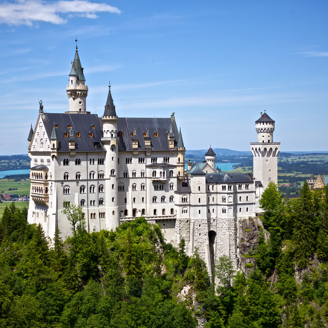

In [58]:
output_im = denoise_model(noise_img[:,:328, :328].unsqueeze(0))
to_img(output_im[0].clip(0,1))

In [55]:
output_srgan = noise_img.numpy()
output_srgan = np.moveaxis(output_srgan, 0, -1)
output_srgan = cv2.fastNlMeansDenoisingColored((output_srgan * 255).astype('uint8'), None,10,10,7,21)
output_srgan = torch.from_numpy(np.moveaxis(output_srgan, -1, 0))
to_img(output_srgan).save("results/denoised-cv2-img.png")

In [ ]:
def denoise_image(img)

In [ ]:
# i trained

fig, ax = plt.subplots(figsize=(20, 15), nrows=3, ncols=6)
for i in range(3):
    img, bicubic, target = val_loader.dataset[i]
    img = AddGaussianNoise(0, 0.1)(img)
    ax_i = ax.flatten()[4*i]
    if i==0:
        ax_i.set_title("image")
    ax_i.imshow(to_img(img))
    ax_i.axis('off')
    
    ax_i = ax.flatten()[4*i+1]
    if i==0:
        ax_i.set_title("target")
    ax_i.imshow(to_img(target))
    ax_i.axis('off')
    
    
    ax_i = ax.flatten()[4*i+2]
    if i==0:
        ax_i.set_title("Predenoise + GAN") 
    pre_srgan = cv2.fastNlMeansDenoisingColored((output_srgan * 255).astype('uint8'), None,10,10,7,21)
    pre_srgan = esrgan(img.unsqueeze(0).to(device))[0]
    pre_srgan = pre_srgan.cpu().detach().numpy().clip(0,1)
    pre_srgan = np.moveaxis(pre_srgan, 0, -1)
    ax_i.imshow(pre_srgan)
        

    ax_i = ax.flatten()[4*i+3]
    if i==0:
        ax_i.set_title("GAN+Postdenoise")
    output_srgan = denoise_esrgan(img.unsqueeze(0).to(device))[0]
    output_srgan = output_srgan.cpu().detach().numpy().clip(0,1)
    output_srgan = np.moveaxis(output_srgan, 0, -1)
    denoise_output_srgan = cv2.fastNlMeansDenoisingColored((output_srgan * 255).astype('uint8'), None,10,10,7,21)
    ax_i.imshow(denoise_output_srgan)
    
    ax_i = ax.flatten()[4*i+4]
    if i==0:
        ax_i.set_title("GAN")
    ax_i.imshow(output_srgan)
    ax_i.axis('off')
    
    ax_i = ax.flatten()[4*i+5]
    if i==0:
        ax_i.set_title("bicubic")
    ax_i.imshow(to_img(bicubic))
    ax_i.axis('off')
    
    
    

# plt.imshow(to_img(srgan(img)[0]))

In [ ]:
!nvidia-smi

In [ ]:
# i trained
fig, ax = plt.subplots(figsize=(20, 15), nrows=3, ncols=4)
for i in range(3):
    img, bicubic, target = val_loader.dataset[i]
#     img = AddGaussianNoise()(img)
    ax_i = ax.flatten()[4*i]
    ax_i.imshow(to_img(img))
    ax_i.axis('off')
    
    ax_i = ax.flatten()[4*i+1]
    ax_i.imshow(to_img(target))
    ax_i.axis('off')
    
    ax_i = ax.flatten()[4*i+2]
    output_srgan = denoise_srgan(img.unsqueeze(0).to(device))[0]
    output_srgan = output_srgan.cpu().detach().numpy().clip(0,1)
    ax_i.imshow(np.moveaxis(output_srgan, 0, -1))
    ax_i.axis('off')
    
    ax_i = ax.flatten()[4*i+3]
    ax_i.imshow(to_img(bicubic))
    ax_i.axis('off')
    
    
    

# plt.imshow(to_img(srgan(img)[0]))

In [ ]:
plt.imshow(to_img(img[0]))

In [ ]:
plt.imshow(to_img(target[0]))

In [ ]:
to_img(img[1][0])
# print((img[1][0])

In [ ]:
import cv2

In [ ]:
noiseimg = img
# print(noiseimg.shape)
noiseimg += np.random.normal(0, 0.15, noiseimg.shape)
noiseimg = noiseimg.permute(1, 2, 0).numpy()
noiseimg = (noiseimg * 255).astype('uint8')
print(noiseimg.shape)
dst = cv2.fastNlMeansDenoisingColored(noiseimg,None,10,10,7,21)
plt.imshow(to_img(noiseimg))
plt.show()
plt.imshow(to_img(dst))

In [ ]:
to_img(noiseimg)

In [ ]:

noiseimg = noiseimg + np.random.normal(0, 10, noiseimg.shape)
noiseimg = np.clip(noiseimg, 0, 255)
plt.imshow(noiseimg)

In [ ]:
noiseimg = np.clip(noiseimg, 0, 255)